In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import logging
logging.root.setLevel(10)
import seaborn as sns; sns.set_theme()

import sys
import json
import os
sys.path.insert(0, os.path.realpath('..'))
os.chdir('..')

from src import data
from src.model import get_splits
with open('config.json', 'r') as cfg:
    config = json.load(cfg)
    
random_seed = 42

In [2]:
#!pip install tueplots
from tueplots import bundles
# global change:
plt.rcParams.update(bundles.neurips2021(usetex=False))

In [3]:
def get_country_name(code):
    country = pycountry.countries.get(alpha_3=code)
    return country.name if country else None


def load_data(config, get_top_level_categories=False):
    return_columns = [
        "Country code", "Country", "Function code", "Function", "Year",
        'Percentage of total expenditure', 'Total expenditure per capita (1000s USD)',
        'Expenditure per capita (1000s USD)', 'Happiness score',
    ]
    data_path = config["data_location"]
    cofog = pd.read_csv(data_path + config["cofog_dataset"])
    happiness = pd.read_csv(data_path + config["happiness_dataset"], sep=';')
    total_spending = pd.read_csv(data_path + config["total_spending_dataset"])

    # Normalize OECD data to percentages of total instead of millions

    cofog.rename(columns={
        "LOCATION": "Country code",
        "ACTIVITY": "Function code"
    }, inplace=True)
    if get_top_level_categories:
        cofog = cofog[cofog["Function code"].str.len() == 3]
    else:
        cofog = cofog[cofog["Function code"].str.len() > 3]

    # Clean-up - null negative expenditures before, which don't make sense, before summing
    cofog.loc[cofog['Value'] < 0, 'Value'] = 0
    totals = cofog.groupby(["Country", "Year"], as_index=False)["Value"].sum()

    cofog = pd.merge(cofog, totals, on=["Country", "Year"])
    cofog = cofog.rename(columns={"Value_x": "Value", "Value_y": "Total expenditure"})
    cofog["Percentage of total expenditure"] = cofog["Value"]/cofog["Total expenditure"]

    # Calculate expenditure per capita in 1000s of USD
    total_spending["Country"] = total_spending["LOCATION"].apply(get_country_name)
    total_spending = total_spending.rename(columns={"TIME": "Year"})
    cofog_merged = pd.merge(cofog, total_spending[["Country", "Year", "Value"]], on=["Country", "Year"])
    cofog_merged = cofog_merged.rename(columns={"Value_y": "Total expenditure per capita (1000s USD)"})
    cofog_merged["Expenditure per capita (1000s USD)"] = \
        cofog_merged["Percentage of total expenditure"]*cofog_merged["Total expenditure per capita (1000s USD)"]

    # Merge in happiness scores
    happiness = happiness.rename(columns={"Country name": "Country", "year": "Year", "Life Ladder": "Happiness score"})
    happiness["Happiness score"] = pd.to_numeric(happiness["Happiness score"].str.replace(',', '.'))
    return pd.merge(cofog_merged, happiness, on=["Country", "Year"])[return_columns]


def filter_bad_data(data):
    essential_columns = ["Year", "Total expenditure per capita (1000s USD)", "Happiness score"]
    non_negative_columns = ['Percentage of total expenditure', 'Expenditure per capita (1000s USD)']

    data_rows_cnt = len(data.index)
    data.dropna(inplace=True)
    logging.info("Dropped {n} rows with NaN values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data != "").any(axis=1)]
    logging.info("Dropped {n} rows with empty string values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data[essential_columns] > 0).any(axis=1)]
    logging.info("Dropped {n} rows with invalid essential columns".format(n=data_rows_cnt - len(data.index)))

    assert not data.isnull().any().any()
    assert not (data == "").any().any()
    assert not (data[essential_columns] <= 0).any().any()
    return data


def create_samples(data):
    """Transforms data into samples with expenditures for each function as a column

    Return a tuple - first element has 'Percentage of total expenditure' as features values, second has
    'Expenditure per capita (1000s USD).'"""
    def make_samples(value_column):
        # Make Function Code values into columns
        pivoted = data.pivot(index=['Country', 'Year'], columns=['Function code'], values=[value_column])

        # Clean up structure
        pivoted.columns = pivoted.columns.get_level_values(1)
        pivoted = pivoted.reset_index()
        pivoted.columns.name = None

        # Missing Country, Year, Function code combinations get nulled
        pivoted = pivoted.where(~pivoted.isnull(), 0)

        return pd.merge(pivoted, data[
            ['Country', 'Year', 'Total expenditure per capita (1000s USD)', 'Happiness score']
        ].drop_duplicates(), on=['Country', 'Year'])

    return make_samples('Percentage of total expenditure'), make_samples('Expenditure per capita (1000s USD)')



In [4]:
whole_data = load_data(config)
whole_data = filter_bad_data(whole_data)
print(whole_data)

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
2              AUT    Austria          0301   
3              AUT    Austria          0401   
4              AUT    Austria          0501   
...            ...        ...           ...   
22106          AUS  Australia          0408   
22107          AUS  Australia          0908   
22108          AUS  Australia          1008   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
2                                        Police services  2008   
3        General economic, commercial and labour affairs  2008   
4                                       Waste management  2008   
...                                    

In [5]:
main_category_code = []
for i, sub_category_code in enumerate(whole_data['Function code']):
    main_category_code.append(whole_data['Function code'][i][0:2])
    
#print(main_category_code)
whole_data = whole_data.assign(Mainfunctioncode=main_category_code)
print(whole_data)

      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
2              AUT    Austria          0301   
3              AUT    Austria          0401   
4              AUT    Austria          0501   
...            ...        ...           ...   
22106          AUS  Australia          0408   
22107          AUS  Australia          0908   
22108          AUS  Australia          1008   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
2                                        Police services  2008   
3        General economic, commercial and labour affairs  2008   
4                                       Waste management  2008   
...                                    

In [10]:
# prepare the heat map
top_dataset = data.load_data(config, True)
top_clean_data = data.filter_bad_data(top_dataset)
top_samples = data.create_samples(top_clean_data)
print(top_samples)

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


(           Country  Year       010       020       030       040       050  \
0        Australia  2007  0.103852  0.051864  0.051228  0.131683  0.018637   
1        Australia  2008  0.097866  0.052709  0.047862  0.125850  0.018790   
2        Australia  2010  0.109954  0.050787  0.048694  0.119985  0.023663   
3        Australia  2011  0.117443  0.048815  0.048092  0.123831  0.026552   
4        Australia  2012  0.113687  0.049221  0.047558  0.122649  0.027521   
..             ...   ...       ...       ...       ...       ...       ...   
341  United States  2015  0.146202  0.086587  0.053079  0.086694  0.000000   
342  United States  2016  0.147965  0.083594  0.052813  0.089555  0.000000   
343  United States  2017  0.148359  0.083216  0.052256  0.090068  0.000000   
344  United States  2018  0.152042  0.084962  0.051972  0.089993  0.000000   
345  United States  2019  0.153338  0.087867  0.051048  0.089780  0.000000   

          060       070       080       090       100  \
0    

In [22]:
parent_data = data.load_data(config, True)

parent_code_mapping = parent_data.groupby(['Function code', 'Function'], as_index=False).sum()[['Function code', 'Function']]
name_main_category = parent_code_mapping["Function"].tolist()
whole_rate_heat.columns=name_main_category
print(whole_rate_heat)

                General public services   Defence  Public order and safety  \
Country                                                                      
Australia                      0.108898  0.053729                 0.048933   
Austria                        0.131505  0.012246                 0.026378   
Belgium                        0.152942  0.016748                 0.033148   
Colombia                       0.153486  0.049105                 0.067093   
Costa Rica                     0.105243  0.000000                 0.078015   
Denmark                        0.133252  0.023536                 0.018560   
Estonia                        0.095792  0.047614                 0.051878   
Finland                        0.146031  0.025005                 0.023232   
France                         0.116460  0.031729                 0.028930   
Germany                        0.138979  0.022013                 0.034465   
Greece                         0.199112  0.048264               

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f970044f970>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f970044f970> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000009.ss000010.ax000011, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib._constrained_layout:left 0.029277
DEBUG:matplotlib._constrained_layout:right 0.012687
DEBUG:matplotlib._constrained_layout:bottom 0.086665
DEBUG:matplotlib._constrained_layout:bbox.y0 0.045280
DEBUG:matplotlib._constrained_layout:pos.y0 0.125000
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000009.ss000010.cbar, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib._constrained_layout:left 0.004630
DEBU

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000009.ss000010.ax000011, (left: 0.000) (bot: 0.000) (right: 0.905) (top: 1.000)
DEBUG:matplotlib._constrained_layout:left 0.124555
DEBUG:matplotlib._constrained_layout:right 0.004571
DEBUG:matplotlib._constrained_layout:bottom 0.321627
DEBUG:matplotlib._constrained_layout:bbox.y0 0.006945
DEBUG:matplotlib._constrained_layout:pos.y0 0.321760
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000009.ss000010.cbar, (left: 0.923) (bot: 0.000) (right: 1.000) (top: 1.000)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib._constrained_layout:left 0.004571
DEBUG:matplotlib._constrained_layout:right 0.040257
DEBUG:matplotlib._constrained_layout:bottom 0.014914
DEBUG:matplotlib._constrained_layout:bbox.y0 0.313658
DEBUG:matplotlib._constrained_layout:pos.y0 0.321760
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000009.ss000010.ax

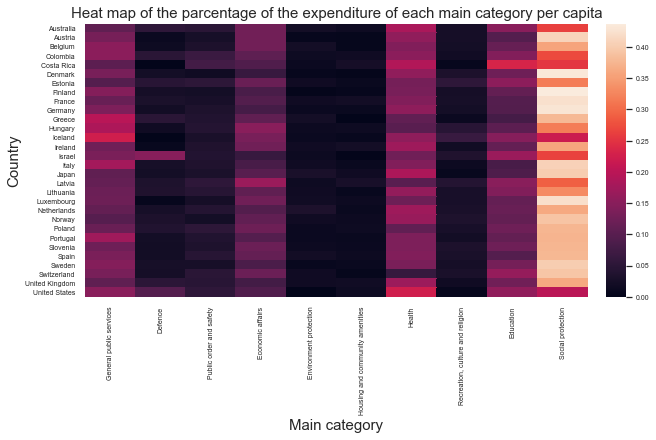

In [23]:
# heat map of the parcentage of the expenditure of each main category per capita
whole_rate_heat = top_samples[0].iloc[:, 0:-2]
whole_rate_heat = whole_rate_heat.groupby(['Country'], as_index=False).mean()
whole_rate_heat = whole_rate_heat.drop('Year', axis=1)
whole_rate_heat = whole_rate_heat.set_index('Country')
whole_rate_heat.columns=name_main_category

fig=plt.figure(figsize=(9,6))
sns.heatmap(whole_rate_heat)

plt.title('Heat map of the parcentage of the expenditure of each main category per capita', fontsize = 15) # title with fontsize 20
plt.xlabel('Main category', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Country', fontsize = 15) # y-axis label with fontsize 15

plt.savefig('Heatmap_parcentage.pdf')
